# GEOG696C Spatiotemporal Data Analysis
## Homework #6: Singular spectral analysis
Alex Saunders | Last updated: 2 November 2023

In [108]:
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt, colors
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as pe
from datetime import datetime
import calendar
import scipy as sp
import xarray as xr
import cartopy
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import scipy.signal

In [2]:
# Set the root path
rootPath = Path('C:/Users/alexa/Documents/GitHub/spatiotemporal_data_analysis/00_hw')
dataPath = Path ('C:/Users/alexa/Documents/01_personal/07_phd/05_study/02_courses/2023/1/GEOG696/data')

## 2. Read global mean annual surface temp anomaly data (Cowland and Way, 2014)

In [13]:
gmst = pd.read_csv(rootPath/'data/gmst.txt', sep='  ', engine='python', index_col=0)

In [14]:
gmst

,t_anomaly_c
year,
1850,-0.390
1851,-0.224
1852,-0.262
1853,-0.322
1854,-0.261
...,...
2014,0.618
2015,0.758
2016,0.870


## 3. Plot the GMST data as a sanity check

In [24]:
gmst.mean(axis=0)

t_anomaly_c   -0.09203
dtype: float64

In [16]:
# Remove the mean
x = gmst - gmst.mean()

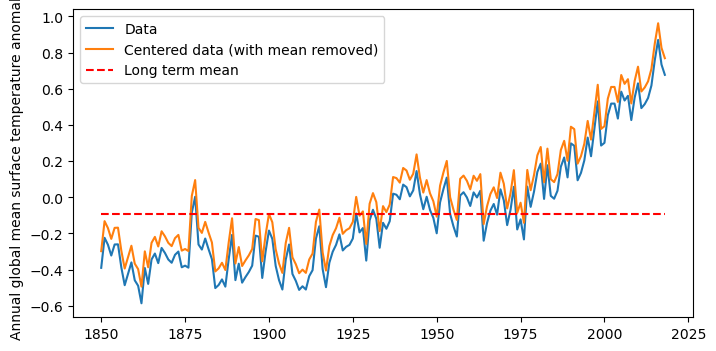

In [31]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(gmst, label='Data')
ax.plot(x, label='Centered data (with mean removed)')
ax.set_ylabel('Annual global mean surface temperature anomaly')

ax.plot([1850,2018], [gmst.mean(),gmst.mean()], 'r--', label='Long term mean')

ax.legend()
plt.show()

In [32]:
N = len(x)
print(N)

169


## 4. Create a trajectory matrix which embeds the original time series
D has each row as a lagged copy of the original time seires, for a given window size defined by the embedding dimension

In [33]:
# Set the embedding dimension
M=60

In [35]:
# Each row of D will have length
print(N-M+1)

110


In [55]:
D=np.zeros([M, N-M+1])
for i in range(M):
    D[i,:] = x[i: N-M+1 + i].t_anomaly_c

In [58]:
print(D.shape)

(60, 110)


## 5. Form the covariance matrix such that it is square M x M

In [59]:
C = np.cov(D, ddof=1)

In [61]:
C.shape

(60, 60)

## 6. Perform SVD on the covariance matrix

In [62]:
U, s, Vt = np.linalg.svd(C)

## 7. Create the signals (PCs) by multipling the EOFs back against the time series

In [65]:
A = U.T @ D

In [69]:
print(A.shape)

(60, 110)


PCs do not have the full length of the original time series, so compute reconstructured components (RCs) instead!

## 8. Construct RCs using convolution

In [73]:
RC=np.zeros([M, N])
for i in range(M):
    RC[i, :] = np.convolve(U[:,i], A[i,:], )[:N]

In [75]:
RC.shape

(60, 169)

In [76]:
## Apply the weights / normalizing
for i in range(N):
    if 0 <= i < M:
        RC[:, i] *= 1 / (i+1)
    elif M-1 <= i < N-M+1:
        RC[:, i] /= M
    else:
        RC[:, i] /= (N-i)

## 9. Calculate the explained variance for each mode

In [80]:
svar = (s / s.sum()) * 100

## 10. Plot the explained variance for each mode

In [84]:
svari = list(range(1, len(svar)+1))

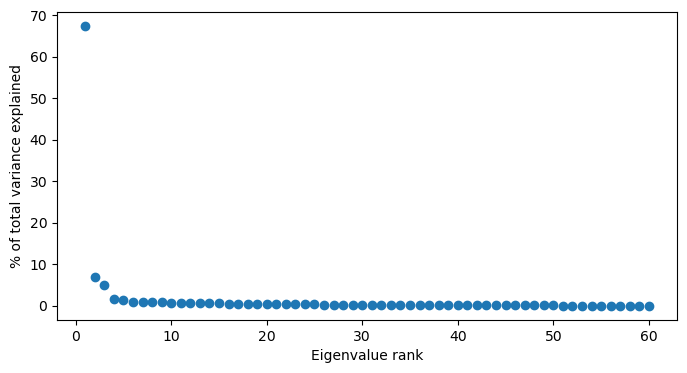

In [87]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(svari, svar, marker='o', linestyle='none')
ax.set_ylabel('% of total variance explained')
ax.set_xlabel('Eigenvalue rank')

plt.show()

### Plot the first 4 eigenvectors

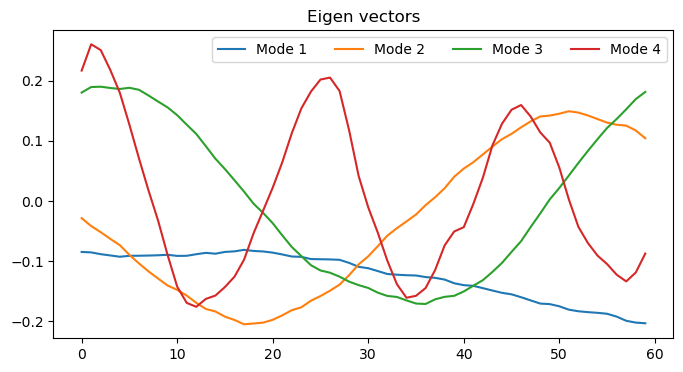

In [102]:
fig, ax = plt.subplots(figsize=(8,4))
ax.set_title('Eigen vectors')

for i in range(4):
    ax.plot(U[:,i], label='Mode '+str(i+1))
ax.legend(ncol=4)

plt.show()

### Plot the first 4 RCs

In [103]:
RC.shape

(60, 169)

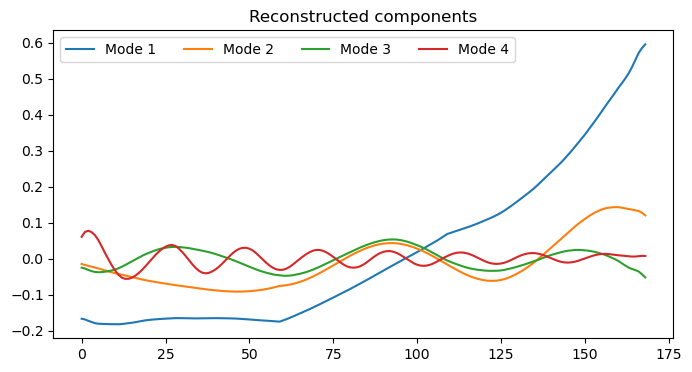

In [104]:
fig, ax = plt.subplots(figsize=(8,4))
ax.set_title('Reconstructed components')

for i in range(4):
    ax.plot(RC[i,:], label='Mode '+str(i+1))
ax.legend(ncol=4)

plt.show()

__What do we see?__

We see similar trends in the eigen vectors versus the RCs, despite them having different length.

Mode 1 appears to represent the long term increasing trend in the temperature data.

Mode 2 is a slowly oscillating signal with freuqency roughly 60 years.

Model 3 has slightly higher frequency.

Mode 4 has a higher frequency of around 20 years.

## 11. Esimate the frequencies (periodicities) of the modes using a periodogram

In [106]:
maxfreqs = np.full(RC.shape[0],np.nan)

In [110]:
for i, row in enumerate(RC):
    # Compute periodogram
    freqs, powers = scipy.signal.periodogram(row)

    # Get the index of the max value in the power spectral density array
    maxi = np.argmax(powers)

    # Get the corresponding freq
    maxfreq = freqs[maxi]

    # Assign this to the corresponding index
    maxfreqs[i]=maxfreq

## 12. Plot the eigenvalues again but with their dominant periodicity

In [113]:
maxfreqs.shape

(60,)

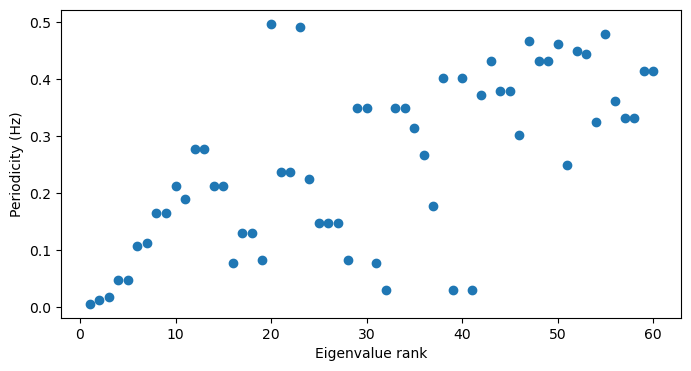

In [116]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(svari, maxfreqs, marker='o', linestyle='none')
ax.set_ylabel('Periodicity (Hz)')
ax.set_xlabel('Eigenvalue rank')

plt.show()

__What do we see?__

The leading modes - as we saw in the RC plot - have very low frequencies (i.e. < 0.01Hz).

At eigen value rank around 20, there are some very high frequency signals (around 0.5 Hz, i.e. 0.5 cycles per second...? This is highly likely to be noise (Gaussian noise)

## 12. Considerations for a Monte Carlo significance test

__How could we devise a Monte Carlo test to determine which of the modes are significant?__

For this, we need to generate realizations of noise, that we can then analyze in place of our data and determine the amount of variance that oculd be explained from modes found purely out of noise (and then compare this to the amount of variance explained by modes from our data).

We could take our data time series, and randomly shuffle the time component i.e. randomly reorder the time series. This way we preserve the total variance. Or, another approach could be to use Gaussian noise.

## 13. Combine and plot RC to yield smoothed versions of the original data

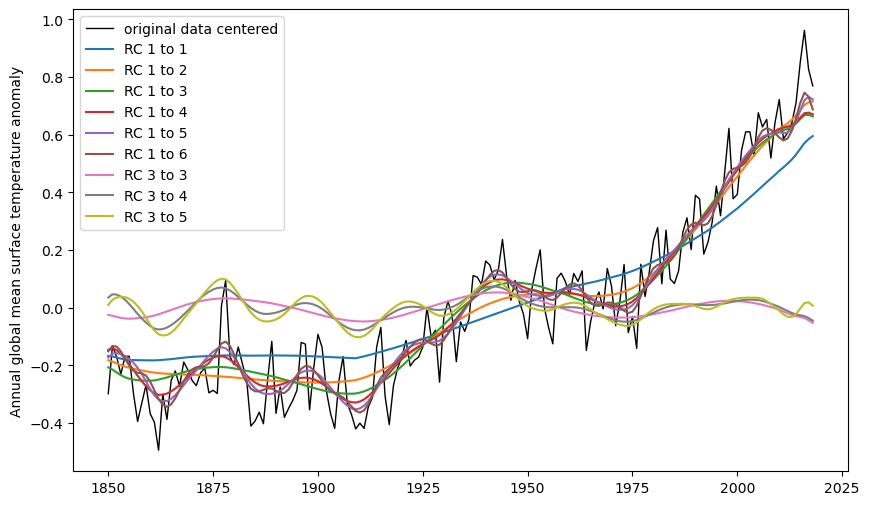

In [140]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x.index, x.t_anomaly_c, 'k', linewidth=1, label='original data centered')

for ns in range(1,7):
    ax.plot(x.index, np.sum(RC[0:ns, :], axis=0), label='RC 1 to '+str(ns))

for ns in range(1,4):
    ax.plot(x.index, np.sum(RC[2:2+ns, :], axis=0), label='RC 3 to '+str(2+ns))
    
ax.set_ylabel('Annual global mean surface temperature anomaly')


ax.legend()

plt.show()

Just plotting RC 3 and upward is helpful as it isolates signals from (i.e. other than) the overall strong increasing trend. I.e. we could use this to recreate the signal without its long term strong upwards trends.

## 14. Sensitivity test on the embedding dimension

Ghil et al. (2002) rule of thumb: take M no larger than N/5 or N/10

In [141]:
N/5

33.8

### Repeat the analysis with M=30 and M=120

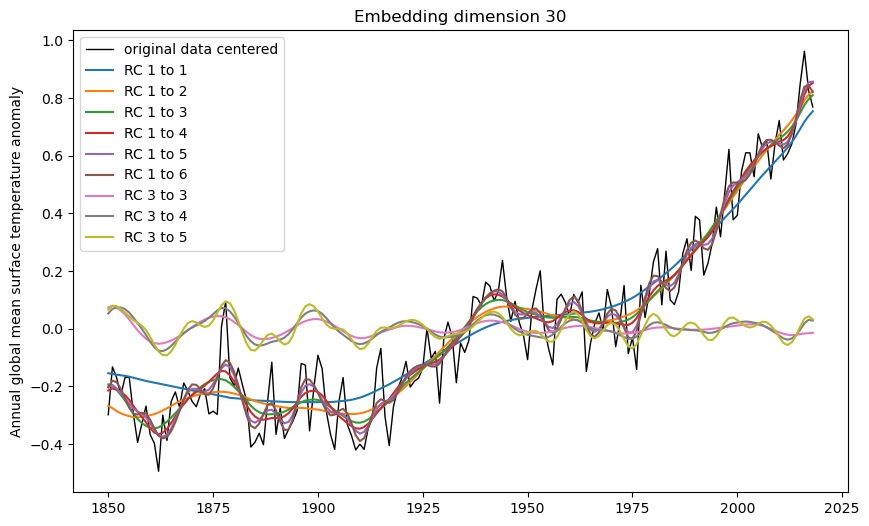

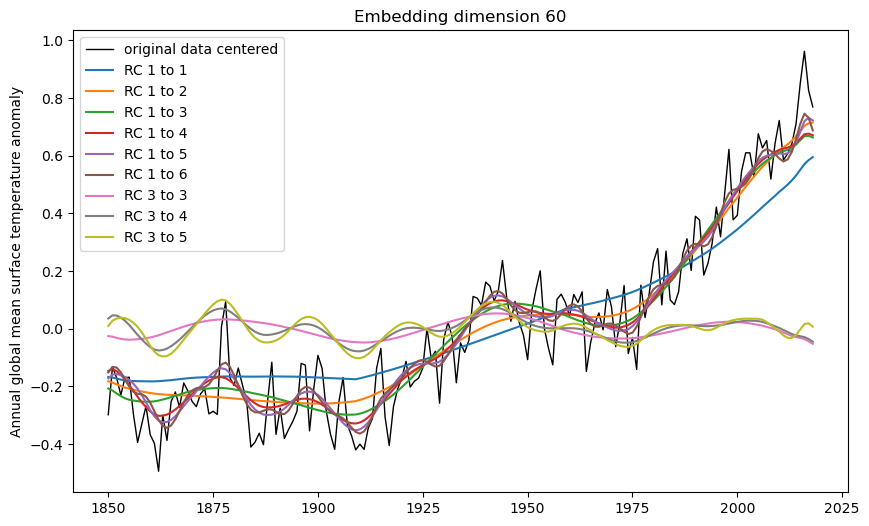

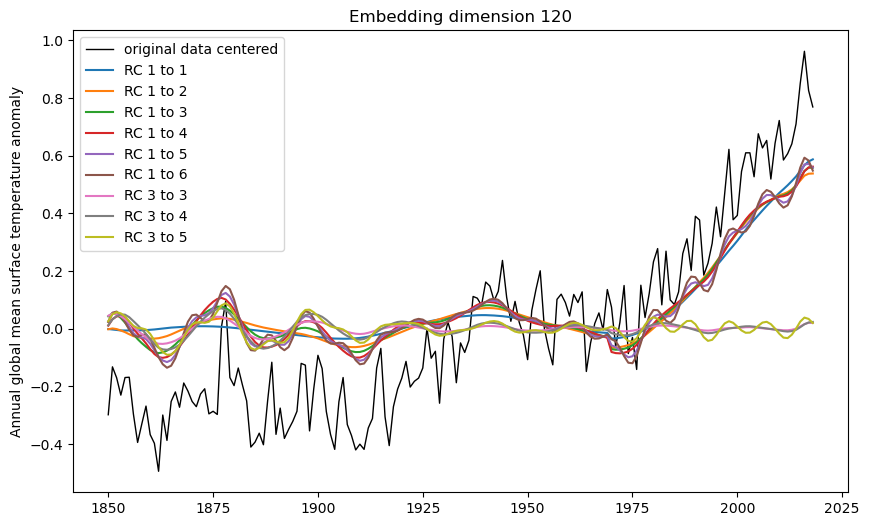

In [143]:
for M in [30, 60, 120]:
    
    D=np.zeros([M, N-M+1])
    for i in range(M):
        D[i,:] = x[i: N-M+1 + i].t_anomaly_c
    
    C = np.cov(D, ddof=1)
    
    U, s, Vt = np.linalg.svd(C)
    
    A = U.T @ D
    
    RC=np.zeros([M, N])
    for i in range(M):
        RC[i, :] = np.convolve(U[:,i], A[i,:], )[:N]
    
    ## Apply the weights / normalizing
    for i in range(N):
        if 0 <= i < M:
            RC[:, i] *= 1 / (i+1)
        elif M-1 <= i < N-M+1:
            RC[:, i] /= M
        else:
            RC[:, i] /= (N-i)
            
    svar = (s / s.sum()) * 100
    svari = list(range(1, len(svar)+1))
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(x.index, x.t_anomaly_c, 'k', linewidth=1, label='original data centered')
    
    for ns in range(1,7):
        ax.plot(x.index, np.sum(RC[0:ns, :], axis=0), label='RC 1 to '+str(ns))
    
    for ns in range(1,4):
        ax.plot(x.index, np.sum(RC[2:2+ns, :], axis=0), label='RC 3 to '+str(2+ns))
        
    ax.set_ylabel('Annual global mean surface temperature anomaly')
    ax.set_title('Embedding dimension {0}'.format(M))
    
    ax.legend()
    
    plt.show()

At large M, we lose capability to decompose and describe the underlying data. M=30 looks much better than the higher values of M for capturing / reproducing the overall long term trend. 